In [1]:
# Import the dependency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import warnings
warnings.filterwarnings('ignore')

2022-11-14 23:23:43.613960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read in the data

- timestamp - A timestamp for the minute covered by the row.
- Asset_ID - An ID code for the cryptoasset.
- Count - The number of trades that took place this minute.
- Open - The USD price at the beginning of the minute.
- High - The highest USD price during the minute.
- Low - The lowest USD price during the minute.
- Close - The USD price at the end of the minute.
- Volume - The number of cryptoasset units traded during the minute.
- VWAP - The volume weighted average price for the minute.
- Target - 15 minute residualized returns. 

In [2]:
crypto_df = pd.read_csv('Resources/train.csv')
crypto_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [3]:
asset_df = pd.read_csv('Resources/asset_details.csv')
asset_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Clean the dataset

In [4]:
# check the datatypes and counts of each column
crypto_df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [5]:
# double check the missing values in each column 
crypto_df.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [6]:
# replace NaN Values with Zeros in Target column
crypto_df["Target"] = crypto_df["Target"].fillna(0)

In [7]:
# show all Rows with NaN Values in VWAP column
# from the output below we can see that all the nan values come from Asset_ID 10
crypto_df[crypto_df["VWAP"].isnull()]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
15004269,1592173560,10,2.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15004283,1592173620,10,4.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15059232,1592426160,10,2.0,529.77,529.77,529.77,529.77,0.0,NaN,0.007356
15143187,1592823720,10,2.0,503.60,503.60,503.60,503.60,0.0,NaN,-0.005672
15183088,1593008940,10,2.0,484.16,484.16,484.16,484.16,0.0,NaN,-0.004281
15184216,1593013920,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184243,1593014040,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184309,1593014340,10,6.0,479.07,479.07,479.07,479.07,0.0,NaN,0.000000
15184778,1593016440,10,4.0,478.00,478.00,475.00,478.00,0.0,NaN,0.000000


In [8]:
# when I clean the data, I found a lot of gaps in data, which influence the consecutive of data visualisation 
# to fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html

In [9]:
# fill gaps for Bitcoin Cash
bit_cash = crypto_df[crypto_df["Asset_ID"]==2].set_index("timestamp")
bit_cash = bit_cash.reindex(range(bit_cash.index[0],bit_cash.index[-1]+60,60),method='pad')
(bit_cash.index[1:]-bit_cash.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [10]:
# fill gaps for Binance Coin
bnc = crypto_df[crypto_df["Asset_ID"]==0].set_index("timestamp")
bnc = bnc.reindex(range(bnc.index[0],bnc.index[-1]+60,60),method='pad')
(bnc.index[1:]-bnc.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [11]:
# fill gaps for Bitcoin 
bit = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
bit = bit.reindex(range(bit.index[0],bit.index[-1]+60,60),method='pad')
(bit.index[1:]-bit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [12]:
# fill gaps for EOS.IO
eos = crypto_df[crypto_df["Asset_ID"]==5].set_index("timestamp")
eos = eos.reindex(range(eos.index[0],eos.index[-1]+60,60),method='pad')
(eos.index[1:]-eos.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [13]:
# fill gaps for Ethereum Classic
eth_classic = crypto_df[crypto_df["Asset_ID"]==7].set_index("timestamp")
eth_classic = eth_classic.reindex(range(eth_classic.index[0],eth_classic.index[-1]+60,60),method='pad')
(eth_classic.index[1:]-eth_classic.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [14]:
# fill gaps for Ethereum
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp")
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
(eth.index[1:]-eth.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [15]:
# fill gaps for Litecoin
lit = crypto_df[crypto_df["Asset_ID"]==9].set_index("timestamp")
lit = lit.reindex(range(lit.index[0],lit.index[-1]+60,60),method='pad')
(lit.index[1:]-lit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [16]:
# fill gaps for Monero
mon = crypto_df[crypto_df["Asset_ID"]==11].set_index("timestamp")
mon = mon.reindex(range(mon.index[0],mon.index[-1]+60,60),method='pad')
(mon.index[1:]-mon.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [17]:
### We find that the start dates of these 6 cryptocurrencies are not from the 2018-01-01, so we are not going to 
### include these in our project.
'''
tro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")
tro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method='pad')
(tro.index[1:]-tro.index[:-1]).value_counts()

ste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")
ste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method='pad')
(ste.index[1:]-ste.index[:-1]).value_counts()

car = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")
car = car.reindex(range(car.index[0],car.index[-1]+60,60),method='pad')
(car.index[1:]-car.index[:-1]).value_counts()

iota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")
iota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method='pad')
(iota.index[1:]-iota.index[:-1]).value_counts()

mak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")
mak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method='pad')
(mak.index[1:]-mak.index[:-1]).value_counts()

dog = crypto_df[crypto_df["Asset_ID"]==4].set_index("timestamp")
dog = dog.reindex(range(dog.index[0],dog.index[-1]+60,60),method='pad')
(dog.index[1:]-dog.index[:-1]).value_counts()
'''

'\ntro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")\ntro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method=\'pad\')\n(tro.index[1:]-tro.index[:-1]).value_counts()\n\nste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")\nste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method=\'pad\')\n(ste.index[1:]-ste.index[:-1]).value_counts()\n\ncar = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")\ncar = car.reindex(range(car.index[0],car.index[-1]+60,60),method=\'pad\')\n(car.index[1:]-car.index[:-1]).value_counts()\n\niota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")\niota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method=\'pad\')\n(iota.index[1:]-iota.index[:-1]).value_counts()\n\nmak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")\nmak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method=\'pad\')\n(mak.index[1:]-mak.index[:-1]).value_counts()\n\ndog = crypto_df[crypto_df["Asset_ID"]

We'll select 6 of the most popular cryptocurrencies to feed in the machine learning model.
Crypto list for analysing: Binance Coin, Bitcoin, EOS.IO, Ethereum, Litecoin, Monero.

In [18]:
# check again to see if there still any missing data left
bnc.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [19]:
bit.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [20]:
eos.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [21]:
eth.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [22]:
lit.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [23]:
mon.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [24]:
# Convert minute data to daily data for each cryptocurrency
# !!! tips: this cell can be run only once, or you may get wrong dataset
# convert minute data to daily data for Binance Coin
bnc.reset_index(inplace=True)
bnc["timestamp"]=bnc["timestamp"].apply(lambda x: x-60) # run only once
bnc["date"]=pd.to_datetime(bnc["timestamp"], unit='s')
# create a new daily DataFrame for Binance Coin
bnc_daily_df=pd.DataFrame(columns=["Asset_ID", "Open", "High", "Low", "Close", "Volume", "VWAP"])
bnc_daily_df['High'] = bnc.groupby(pd.Grouper(freq='D', key='date')).max()['High']
bnc_daily_df['Low'] = bnc.groupby(pd.Grouper(freq='D', key='date')).min()['Low']
bnc_daily_df['Open'] = bnc.Open[0:-1:24*60].values
bnc_daily_df['Close'] = bnc.Close[24*60-1:len(bnc):24*60].values
bnc_daily_df['Asset_ID'] = bnc.Asset_ID[0:-1:24*60].values
bnc_daily_df['Volume'] = bnc.groupby(pd.Grouper(freq='D', key='date')).sum()['Volume']
bnc_daily_df['VWAP'] = bnc.groupby(pd.Grouper(freq='D', key='date')).mean()['VWAP']

# convert minute data to daily data for Bitcoin
bit.reset_index(inplace=True)
bit["timestamp"]=bit["timestamp"].apply(lambda x: x-60) # run only once
bit["date"]=pd.to_datetime(bit["timestamp"], unit='s')
# create a new daily DataFrame for Bitcoin
bit_daily_df=pd.DataFrame(columns=["Asset_ID", "Open", "High", "Low", "Close", "Volume", "VWAP"])
bit_daily_df['High'] = bit.groupby(pd.Grouper(freq='D', key='date')).max()['High']
bit_daily_df['Low'] = bit.groupby(pd.Grouper(freq='D', key='date')).min()['Low']
bit_daily_df['Open'] = bit.Open[0:-1:24*60].values
bit_daily_df['Close'] = bit.Close[24*60-1:len(bit):24*60].values
bit_daily_df['Asset_ID'] = bit.Asset_ID[0:-1:24*60].values
bit_daily_df['Volume'] = bit.groupby(pd.Grouper(freq='D', key='date')).sum()['Volume']
bit_daily_df['VWAP'] = bit.groupby(pd.Grouper(freq='D', key='date')).mean()['VWAP']

# convert minute data to daily data for EOS.IO
eos.reset_index(inplace=True)
eos["timestamp"]=eos["timestamp"].apply(lambda x: x-60) # run only once
eos["date"]=pd.to_datetime(eos["timestamp"], unit='s')
# create a new daily DataFrame for EOS.IO
eos_daily_df=pd.DataFrame(columns=["Asset_ID", "Open", "High", "Low", "Close", "Volume", "VWAP"])
eos_daily_df['High'] = eos.groupby(pd.Grouper(freq='D', key='date')).max()['High']
eos_daily_df['Low'] = eos.groupby(pd.Grouper(freq='D', key='date')).min()['Low']
eos_daily_df['Open'] = eos.Open[0:-1:24*60].values
eos_daily_df['Close'] = eos.Close[24*60-1:len(eos):24*60].values
eos_daily_df['Asset_ID'] = eos.Asset_ID[0:-1:24*60].values
eos_daily_df['Volume'] = eos.groupby(pd.Grouper(freq='D', key='date')).sum()['Volume']
eos_daily_df['VWAP'] = eos.groupby(pd.Grouper(freq='D', key='date')).mean()['VWAP']

# convert minute data to daily data for Ethereum
eth.reset_index(inplace=True)
eth["timestamp"]=eth["timestamp"].apply(lambda x: x-60) # run only once
eth["date"]=pd.to_datetime(eth["timestamp"], unit='s')
# create a new daily DataFrame for Ethereum
eth_daily_df=pd.DataFrame(columns=["Asset_ID", "Open", "High", "Low", "Close", "Volume", "VWAP"])
eth_daily_df['High'] = eth.groupby(pd.Grouper(freq='D', key='date')).max()['High']
eth_daily_df['Low'] = eth.groupby(pd.Grouper(freq='D', key='date')).min()['Low']
eth_daily_df['Open'] = eth.Open[0:-1:24*60].values
eth_daily_df['Close'] = eth.Close[24*60-1:len(eth):24*60].values
eth_daily_df['Asset_ID'] = eth.Asset_ID[0:-1:24*60].values
eth_daily_df['Volume'] = eth.groupby(pd.Grouper(freq='D', key='date')).sum()['Volume']
eth_daily_df['VWAP'] = eth.groupby(pd.Grouper(freq='D', key='date')).mean()['VWAP']

# convert minute data to daily data for Litecoin
lit.reset_index(inplace=True)
lit["timestamp"]=lit["timestamp"].apply(lambda x: x-60) # run only once
lit["date"]=pd.to_datetime(lit["timestamp"], unit='s')
# create a new daily DataFrame for Litecoin
lit_daily_df=pd.DataFrame(columns=["Asset_ID", "Open", "High", "Low", "Close", "Volume", "VWAP"])
lit_daily_df['High'] = lit.groupby(pd.Grouper(freq='D', key='date')).max()['High']
lit_daily_df['Low'] = lit.groupby(pd.Grouper(freq='D', key='date')).min()['Low']
lit_daily_df['Open'] = lit.Open[0:-1:24*60].values
lit_daily_df['Close'] = lit.Close[24*60-1:len(lit):24*60].values
lit_daily_df['Asset_ID'] = lit.Asset_ID[0:-1:24*60].values
lit_daily_df['Volume'] = lit.groupby(pd.Grouper(freq='D', key='date')).sum()['Volume']
lit_daily_df['VWAP'] = lit.groupby(pd.Grouper(freq='D', key='date')).mean()['VWAP']

# convert minute data to daily data for Monero
mon.reset_index(inplace=True)
mon["timestamp"]=mon["timestamp"].apply(lambda x: x-60) # run only once
mon["date"]=pd.to_datetime(mon["timestamp"], unit='s')
# create a new daily DataFrame for Monero
mon_daily_df=pd.DataFrame(columns=["Asset_ID", "Open", "High", "Low", "Close", "Volume", "VWAP"])
mon_daily_df['High'] = mon.groupby(pd.Grouper(freq='D', key='date')).max()['High']
mon_daily_df['Low'] = mon.groupby(pd.Grouper(freq='D', key='date')).min()['Low']
mon_daily_df['Open'] = mon.Open[0:-1:24*60].values
mon_daily_df['Close'] = mon.Close[24*60-1:len(mon):24*60].values
mon_daily_df['Asset_ID'] = mon.Asset_ID[0:-1:24*60].values
mon_daily_df['Volume'] = mon.groupby(pd.Grouper(freq='D', key='date')).sum()['Volume']
mon_daily_df['VWAP'] = mon.groupby(pd.Grouper(freq='D', key='date')).mean()['VWAP']

In [25]:
# check each crypto daily DataFrame
bnc_daily_df.head()

,Asset_ID,Open,High,Low,Close,Volume,VWAP
date,,,,,,,
2018-01-01,0,8.530,8.7000,7.8000,8.4381,663279.30,8.268735
2018-01-02,0,8.463,9.1133,8.0922,8.6996,1267257.37,8.523795
2018-01-03,0,8.711,9.4697,8.2653,9.2880,945805.40,8.705238
2018-01-04,0,9.288,9.6511,8.5595,9.1215,986443.42,9.048950
2018-01-05,0,9.135,16.8172,8.9651,15.0045,2767053.79,11.863208


In [26]:
bit_daily_df.head()

,Asset_ID,Open,High,Low,Close,Volume,VWAP
date,,,,,,,
2018-01-01,1,13835.194,14442.9,12750.00,13468.698,57889.811032,13439.704032
2018-01-02,1,13459.606,15500.0,12798.00,14743.424,105541.245764,13885.548774
2018-01-03,1,14739.148,15599.7,14150.00,15107.792,83829.059632,14968.234757
2018-01-04,1,15096.770,15500.1,13918.04,15158.492,101148.935997,14820.300206
2018-01-05,1,15158.346,17200.0,14600.00,16935.556,108673.177856,15828.101106


In [27]:
eos_daily_df.head()

,Asset_ID,Open,High,Low,Close,Volume,VWAP
date,,,,,,,
2018-01-01,5,7.6596,7.9500,7.2000,7.6401,1.833038e+06,7.642579
2018-01-02,5,7.6580,8.6000,7.6220,8.3090,4.289508e+06,8.156979
2018-01-03,5,8.3099,9.4362,7.8343,9.4053,4.026631e+06,8.239224
2018-01-04,5,9.3980,10.5030,9.1500,9.4039,7.347625e+06,9.763804
2018-01-05,5,9.4000,9.8500,8.5079,9.2197,4.016998e+06,9.112319


In [28]:
eth_daily_df.head()

,Asset_ID,Open,High,Low,Close,Volume,VWAP
date,,,,,,,
2018-01-01,6,738.3025,772.98,716.80,757.3900,273985.132071,745.603094
2018-01-02,6,757.7250,899.50,749.06,859.6750,852029.274081,847.222352
2018-01-03,6,859.9000,954.73,810.00,935.4225,673171.535709,882.655306
2018-01-04,6,935.4100,1009.72,890.01,941.2525,745961.212684,946.640937
2018-01-05,6,941.1150,1045.00,900.00,961.6100,664055.044597,976.191724


In [29]:
lit_daily_df.head()

,Asset_ID,Open,High,Low,Close,Volume,VWAP
date,,,,,,,
2018-01-01,9,225.330,237.77,212.74,223.900,4.791826e+05,223.977396
2018-01-02,9,224.384,265.00,222.75,251.286,1.180959e+06,245.318321
2018-01-03,9,251.212,261.49,233.56,243.256,8.375442e+05,247.796651
2018-01-04,9,242.858,245.30,219.38,238.132,1.067847e+06,234.101773
2018-01-05,9,237.502,260.00,230.00,242.958,1.024284e+06,243.604162


In [30]:
mon_daily_df.head()

,Asset_ID,Open,High,Low,Close,Volume,VWAP
date,,,,,,,
2018-01-01,11,329.090,348.30,316.06,340.345,28705.203327,330.756130
2018-01-02,11,340.625,373.74,320.00,365.160,70579.154791,355.406804
2018-01-03,11,365.000,390.00,359.01,385.030,54107.818566,374.584449
2018-01-04,11,385.305,391.79,352.29,371.000,54597.627423,372.304257
2018-01-05,11,373.320,388.00,340.03,356.125,58925.429126,362.861913


## Merge the clean dataset together

In [31]:
# merge all the data together
frames = [bnc_daily_df, bit_daily_df, eos_daily_df, eth_daily_df, lit_daily_df, mon_daily_df]
crypto_con_df = pd.concat(frames)
# use the index to sort the values
crypto_con_df = crypto_con_df.sort_index()
# Convert Index into Column
crypto_con_df.reset_index(inplace=True)
# merge crypto_con_df with DataFrame contains asset details
crypto_daily_df = pd.merge(crypto_con_df, asset_df, how="left", on=["Asset_ID", "Asset_ID"])
new_column_order = ["date","Asset_ID","Asset_Name","Weight","Open","High","Low","Close","Volume","VWAP"]
crypto_daily_df = crypto_daily_df[new_column_order]
crypto_daily_df.head()

,date,Asset_ID,Asset_Name,Weight,Open,High,Low,Close,Volume,VWAP
0,2018-01-01,0,Binance Coin,4.304065,8.5300,8.70,7.80,8.4381,6.632793e+05,8.268735
1,2018-01-01,9,Litecoin,2.397895,225.3300,237.77,212.74,223.9000,4.791826e+05,223.977396
2,2018-01-01,6,Ethereum,5.894403,738.3025,772.98,716.80,757.3900,2.739851e+05,745.603094
3,2018-01-01,5,EOS.IO,1.386294,7.6596,7.95,7.20,7.6401,1.833038e+06,7.642579
4,2018-01-01,1,Bitcoin,6.779922,13835.1940,14442.90,12750.00,13468.6980,5.788981e+04,13439.704032


In [32]:
# export data into a CSV
output_data_file = "Data/crypto_daily.csv"
#crypto_daily_df.to_csv(output_data_file, index=False)

## Split training and testing data for each cryptocurrency

In [33]:
# Split training and testing data for Binance Coin
bnc_train = bnc_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
bnc_test = bnc_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_bnc_train = bnc_train[["High", "Low", "VWAP"]]
X_bnc_test = bnc_test[["High", "Low", "VWAP"]]
y_bnc_train = bnc_train.Close.values.reshape(-1, 1)
y_bnc_test = bnc_test.Close.values.reshape(-1, 1)

# Split training and testing data for Bitcoin
bit_train = bit_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
bit_test = bit_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_bit_train = bit_train[["High", "Low", "VWAP"]]
X_bit_test = bit_test[["High", "Low", "VWAP"]]
y_bit_train = bit_train.Close.values.reshape(-1, 1)
y_bit_test = bit_test.Close.values.reshape(-1, 1)

# Split training and testing data for EOS.IO
eos_train = eos_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
eos_test = eos_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_eos_train = eos_train[["High", "Low", "VWAP"]]
X_eos_test = eos_test[["High", "Low", "VWAP"]]
y_eos_train = eos_train.Close.values.reshape(-1, 1)
y_eos_test = eos_test.Close.values.reshape(-1, 1)

# Split training and testing data for Ethereum
eth_train = eth_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
eth_test = eth_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_eth_train = eth_train[["High", "Low", "VWAP"]]
X_eth_test = eth_test[["High", "Low", "VWAP"]]
y_eth_train = eth_train.Close.values.reshape(-1, 1)
y_eth_test = eth_test.Close.values.reshape(-1, 1)

# Split training and testing data for Litecoin
lit_train = lit_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
lit_test = lit_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_lit_train = lit_train[["High", "Low", "VWAP"]]
X_lit_test = lit_test[["High", "Low", "VWAP"]]
y_lit_train = lit_train.Close.values.reshape(-1, 1)
y_lit_test = lit_test.Close.values.reshape(-1, 1)

# Split training and testing data for Monero
mon_train = mon_daily_df[0:1096] # Start from 2018-01-01 to 2021-01-01 
mon_test = mon_daily_df[1096:] # Start from 2021-01-01 to 2021-09-20 
X_mon_train = mon_train[["High", "Low", "VWAP"]]
X_mon_test = mon_test[["High", "Low", "VWAP"]]
y_mon_train = mon_train.Close.values.reshape(-1, 1)
y_mon_test = mon_test.Close.values.reshape(-1, 1)

## Scale the traning and testing data

In [34]:
# Create a StandardScaler instances
scaler = StandardScaler()
X_bnc_scaler = scaler.fit(X_bnc_train)
X_bit_scaler = scaler.fit(X_bit_train)
X_eos_scaler = scaler.fit(X_eos_train)
X_eth_scaler = scaler.fit(X_eth_train)
X_lit_scaler = scaler.fit(X_lit_train)
X_mon_scaler = scaler.fit(X_mon_train)

# Scale the data for those six cryptocurrencies
X_bnc_train_scaled = X_bnc_scaler.transform(X_bnc_train)
X_bnc_test_scaled = X_bnc_scaler.transform(X_bnc_test)

X_bit_train_scaled = X_bit_scaler.transform(X_bit_train)
X_bit_test_scaled = X_bit_scaler.transform(X_bit_test)

X_eos_train_scaled = X_eos_scaler.transform(X_eos_train)
X_eos_test_scaled = X_eos_scaler.transform(X_eos_test)

X_eth_train_scaled = X_eth_scaler.transform(X_eth_train)
X_eth_test_scaled = X_eth_scaler.transform(X_eth_test)

X_lit_train_scaled = X_lit_scaler.transform(X_lit_train)
X_lit_test_scaled = X_lit_scaler.transform(X_lit_test)

X_mon_train_scaled = X_mon_scaler.transform(X_mon_train)
X_mon_test_scaled = X_mon_scaler.transform(X_mon_test)

## Create machine learning model
### 1. LinearRegression

In [35]:
# Train the data using LinearRegression
lr_model = LinearRegression()

lr_model.fit(X_bnc_train_scaled,y_bnc_train)
y_pred_lr_bnc = lr_model.predict(X_bnc_test_scaled)

lr_model.fit(X_bit_train_scaled,y_bit_train)
y_pred_lr_bit = lr_model.predict(X_bit_test_scaled)

lr_model.fit(X_eos_train_scaled,y_eos_train)
y_pred_lr_eos = lr_model.predict(X_eos_test_scaled)

lr_model.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr_model.predict(X_eth_test_scaled)

lr_model.fit(X_lit_train_scaled,y_lit_train)
y_pred_lr_lit = lr_model.predict(X_lit_test_scaled)

lr_model.fit(X_mon_train_scaled,y_mon_train)
y_pred_lr_mon = lr_model.predict(X_mon_test_scaled)

In [36]:
print(f"Test Score for Binance Coin: {r2_score(y_bnc_test, y_pred_lr_bnc):.3f}")
print(f"Test Score for Bitcoin: {r2_score(y_bit_test, y_pred_lr_bit):.3f}")  
print(f"Test Score for EOS.IO: {r2_score(y_eos_test, y_pred_lr_eos):.3f}")  
print(f"Test Score for Ethereum: {r2_score(y_eth_test, y_pred_lr_eth):.3f}")  
print(f"Test Score for Litecoin: {r2_score(y_lit_test, y_pred_lr_lit):.3f}")  
print(f"Test Score for Monero: {r2_score(y_mon_test, y_pred_lr_mon):.3f}") 

Test Score for Binance Coin: 0.993
Test Score for Bitcoin: 0.985
Test Score for EOS.IO: 0.964
Test Score for Ethereum: 0.990
Test Score for Litecoin: 0.980
Test Score for Monero: 0.976


### 4. Artificial Neural Network
I am using two hidden layers with five neurons each and one output layer with one neuron.
- units=5: This means we are creating a layer with five neurons in it. 
- input_dim=3: This means there are 3 predictors in the input data which is expected by the first layer. 
- kernel_initializer=’normal’: When the Neurons start their computation, some algorithm has to decide the value for each weight. This parameter specifies that. 
- activation=’relu’: This specifies the activation function for the calculations inside each neuron. 
- batch_size=20: This specifies how many rows will be passed to the Network in one go after which the SSE calculation will begin and the neural network will start adjusting its weights based on the errors. 
- Epochs=50: The same activity of adjusting weights continues for 50 times, as specified by this parameter.

In [37]:
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and First hidden layer
model.add(Dense(units=5, input_dim=3, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
 
# Fitting the ANN to the Training set
model.fit(X_bnc_train_scaled, y_bnc_train, batch_size = 10,epochs = 100, verbose=1)

# Generating Predictions on testing data
y_pred_nn_bnc=model.predict(X_bnc_test_scaled)

2022-11-14 23:24:52.676753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
110/110 [==============================] - 2s 4ms/step - loss: 362.0649 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 329.3587 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 236.1149 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 127.2393 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 82.4373 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 77.5171 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 77.2581 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 76.9793 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 76.7984 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [====================

110/110 [==============================] - 0s 2ms/step - loss: 50.6783 - accuracy: 0.0000e+00
Epoch 78/100
110/110 [==============================] - 0s 2ms/step - loss: 49.4873 - accuracy: 0.0000e+00
Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 48.1591 - accuracy: 0.0000e+00
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 46.7140 - accuracy: 0.0000e+00
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 45.3071 - accuracy: 0.0000e+00
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 43.6356 - accuracy: 0.0000e+00
Epoch 83/100
110/110 [==============================] - 0s 2ms/step - loss: 41.9496 - accuracy: 0.0000e+00
Epoch 84/100
110/110 [==============================] - 0s 2ms/step - loss: 40.0760 - accuracy: 0.0000e+00
Epoch 85/100
110/110 [==============================] - 0s 2ms/step - loss: 38.1636 - accuracy: 0.0000e+00
Epoch 86/100
110/110 [============================

In [38]:
# Fitting the ANN to the Training set
model.fit(X_bit_train_scaled, y_bit_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_bit=model.predict(X_bit_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 1505770.7500 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 39296.6992 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 38605.5508 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 38749.4219 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 39080.2852 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 39062.1523 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 38787.7383 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 38919.1914 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 38841.9141 - accuracy: 0.0000e+00
Epoch 10/100
110/

110/110 [==============================] - 0s 2ms/step - loss: 38198.0469 - accuracy: 0.0000e+00
Epoch 76/100
110/110 [==============================] - 0s 2ms/step - loss: 38586.4609 - accuracy: 0.0000e+00
Epoch 77/100
110/110 [==============================] - 0s 2ms/step - loss: 38433.6562 - accuracy: 0.0000e+00
Epoch 78/100
110/110 [==============================] - 0s 2ms/step - loss: 38564.8633 - accuracy: 0.0000e+00
Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 39593.1797 - accuracy: 0.0000e+00
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 38811.4180 - accuracy: 0.0000e+00
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 40327.5391 - accuracy: 0.0000e+00
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 37995.9609 - accuracy: 0.0000e+00
Epoch 83/100
110/110 [==============================] - 0s 2ms/step - loss: 38996.1953 - accuracy: 0.0000e+00
Epoch 84/100
110/110 [=

In [39]:
# Fitting the ANN to the Training set
model.fit(X_eos_train_scaled, y_eos_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_eos=model.predict(X_eos_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0938 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0840 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0823 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0791 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0788 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0771 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0771 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0806 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0767 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [========================

110/110 [==============================] - 0s 2ms/step - loss: 10.0834 - accuracy: 0.0000e+00
Epoch 78/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0817 - accuracy: 0.0000e+00
Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0852 - accuracy: 0.0000e+00
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0829 - accuracy: 0.0000e+00
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0869 - accuracy: 0.0000e+00
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0887 - accuracy: 0.0000e+00
Epoch 83/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0801 - accuracy: 0.0000e+00
Epoch 84/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0802 - accuracy: 0.0000e+00
Epoch 85/100
110/110 [==============================] - 0s 2ms/step - loss: 10.0822 - accuracy: 0.0000e+00
Epoch 86/100
110/110 [============================

In [40]:
# Fitting the ANN to the Training set
model.fit(X_eth_train_scaled, y_eth_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_eth=model.predict(X_eth_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 1162.0771 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 602.5928 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 400.3387 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 288.8086 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 224.6317 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 184.9256 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 164.1695 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 153.1235 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 146.8664 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [==============

110/110 [==============================] - 0s 3ms/step - loss: 139.3628 - accuracy: 0.0000e+00
Epoch 77/100
110/110 [==============================] - 0s 2ms/step - loss: 136.6290 - accuracy: 0.0000e+00
Epoch 78/100
110/110 [==============================] - 0s 2ms/step - loss: 137.8728 - accuracy: 0.0000e+00
Epoch 79/100
110/110 [==============================] - 0s 3ms/step - loss: 140.2226 - accuracy: 0.0000e+00
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 137.1680 - accuracy: 0.0000e+00
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 138.6318 - accuracy: 0.0000e+00
Epoch 82/100
110/110 [==============================] - 1s 5ms/step - loss: 138.1349 - accuracy: 0.0000e+00
Epoch 83/100
110/110 [==============================] - 0s 4ms/step - loss: 138.5956 - accuracy: 0.0000e+00
Epoch 84/100
110/110 [==============================] - 0s 4ms/step - loss: 139.4276 - accuracy: 0.0000e+00
Epoch 85/100
110/110 [===================

In [41]:
# Fitting the ANN to the Training set
model.fit(X_lit_train_scaled, y_lit_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_lit=model.predict(X_lit_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 7.5518 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 7.5174 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 7.4939 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 7.4890 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 7.4842 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 7.4712 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 7.4697 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 3ms/step - loss: 7.4690 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 3ms/step - loss: 7.4870 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [==============================] -

110/110 [==============================] - 0s 2ms/step - loss: 7.5050 - accuracy: 0.0000e+00
Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 7.6183 - accuracy: 0.0000e+00
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 7.6127 - accuracy: 0.0000e+00
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 7.3750 - accuracy: 0.0000e+00
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 7.5535 - accuracy: 0.0000e+00
Epoch 83/100
110/110 [==============================] - 0s 2ms/step - loss: 7.6456 - accuracy: 0.0000e+00
Epoch 84/100
110/110 [==============================] - 0s 2ms/step - loss: 7.4060 - accuracy: 0.0000e+00
Epoch 85/100
110/110 [==============================] - 0s 2ms/step - loss: 7.5056 - accuracy: 0.0000e+00
Epoch 86/100
110/110 [==============================] - 0s 2ms/step - loss: 7.4901 - accuracy: 0.0000e+00
Epoch 87/100
110/110 [==============================] - 0s 

In [42]:
# Fitting the ANN to the Training set
model.fit(X_mon_train_scaled, y_mon_train, batch_size = 10,epochs = 100, verbose=1)
# Generating Predictions on testing data
y_pred_nn_mon=model.predict(X_mon_test_scaled)

Epoch 1/100
110/110 [==============================] - 0s 3ms/step - loss: 34.4543 - accuracy: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 33.9818 - accuracy: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 33.1314 - accuracy: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 32.4646 - accuracy: 0.0000e+00
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 31.2176 - accuracy: 0.0000e+00
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 31.0218 - accuracy: 0.0000e+00
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 29.5994 - accuracy: 0.0000e+00
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 29.8707 - accuracy: 0.0000e+00
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 29.5642 - accuracy: 0.0000e+00
Epoch 10/100
110/110 [========================

110/110 [==============================] - 0s 2ms/step - loss: 24.1633 - accuracy: 0.0000e+00
Epoch 78/100
110/110 [==============================] - 0s 2ms/step - loss: 23.8508 - accuracy: 0.0000e+00
Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 23.0558 - accuracy: 0.0000e+00
Epoch 80/100
110/110 [==============================] - 0s 2ms/step - loss: 22.8690 - accuracy: 0.0000e+00
Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 23.2268 - accuracy: 0.0000e+00
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 23.4144 - accuracy: 0.0000e+00
Epoch 83/100
110/110 [==============================] - 0s 2ms/step - loss: 22.9333 - accuracy: 0.0000e+00
Epoch 84/100
110/110 [==============================] - 0s 2ms/step - loss: 23.2368 - accuracy: 0.0000e+00
Epoch 85/100
110/110 [==============================] - 0s 2ms/step - loss: 23.0486 - accuracy: 0.0000e+00
Epoch 86/100
110/110 [============================

In [43]:
print(f"Test Score for Binance Coin: {r2_score(y_bnc_test, y_pred_nn_bnc):.3f}")
print(f"Test Score for Bitcoin: {r2_score(y_bit_test, y_pred_nn_bit):.3f}")  
print(f"Test Score for EOS.IO: {r2_score(y_eos_test, y_pred_nn_eos):.3f}")  
print(f"Test Score for Ethereum: {r2_score(y_eth_test, y_pred_nn_eth):.3f}")  
print(f"Test Score for Litecoin: {r2_score(y_lit_test, y_pred_nn_lit):.3f}")  
print(f"Test Score for Monero: {r2_score(y_mon_test, y_pred_nn_mon):.3f}") 

Test Score for Binance Coin: 0.351
Test Score for Bitcoin: 0.986
Test Score for EOS.IO: -0.000
Test Score for Ethereum: 0.990
Test Score for Litecoin: 0.980
Test Score for Monero: 0.976


### Finding best set of neural network parameters using manual grid search
Finding the best values for batch_size and epoch is very important as it directly affects the model performance. Bad values can lead to overfitting or underfitting. 
Apart from epoch and batch_size, you can also choose to tune the optimal number of neurons, the optimal number of layers, etc.

In [75]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 20]
    epoch_list  =   [10, 50, 100]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
            # Defining the Output layer of the model
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
 
######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_bnc_train_scaled, y_bnc_train, X_bnc_test_scaled, y_bnc_test)

9/9 [==============================] - 0s 2ms/step
1 Parameters: batch_size: 5 - epochs: 10 Accuracy: 5.442535314403202
9/9 [==============================] - 0s 2ms/step
2 Parameters: batch_size: 5 - epochs: 50 Accuracy: 7.138528713358568
9/9 [==============================] - 0s 2ms/step
3 Parameters: batch_size: 5 - epochs: 100 Accuracy: 9.790089815269809
9/9 [==============================] - 0s 3ms/step
4 Parameters: batch_size: 10 - epochs: 10 Accuracy: 5.2799501504476325
9/9 [==============================] - 0s 2ms/step
5 Parameters: batch_size: 10 - epochs: 50 Accuracy: 5.923430551121541
9/9 [==============================] - 0s 2ms/step
6 Parameters: batch_size: 10 - epochs: 100 Accuracy: 10.938517009641203
9/9 [==============================] - 0s 2ms/step
7 Parameters: batch_size: 20 - epochs: 10 Accuracy: 4.978091086220587
9/9 [==============================] - 0s 3ms/step
8 Parameters: batch_size: 20 - epochs: 50 Accuracy: 1.5722721635951586
9/9 [=========================

In [80]:
# Calling the function
ResultsData=FunctionFindBestParams(X_bit_train_scaled, y_bit_train, X_bit_test_scaled, y_bit_test)

9/9 [==============================] - 0s 2ms/step
1 Parameters: batch_size: 5 - epochs: 10 Accuracy: 98.07733417989543
9/9 [==============================] - 0s 2ms/step
2 Parameters: batch_size: 5 - epochs: 50 Accuracy: 98.04133300561735
9/9 [==============================] - 0s 2ms/step
3 Parameters: batch_size: 5 - epochs: 100 Accuracy: 98.07300212873655
9/9 [==============================] - 2s 3ms/step
4 Parameters: batch_size: 10 - epochs: 10 Accuracy: 84.78181537555248
9/9 [==============================] - 0s 3ms/step
5 Parameters: batch_size: 10 - epochs: 50 Accuracy: 98.02639905962079
9/9 [==============================] - 0s 2ms/step
6 Parameters: batch_size: 10 - epochs: 100 Accuracy: 98.06794724423652
9/9 [==============================] - 0s 2ms/step
7 Parameters: batch_size: 20 - epochs: 10 Accuracy: 61.261594615019824
9/9 [==============================] - 0s 3ms/step
8 Parameters: batch_size: 20 - epochs: 50 Accuracy: 98.0270910703557
9/9 [============================

In [81]:
# Calling the function
ResultsData=FunctionFindBestParams(X_eos_train_scaled, y_eos_train, X_eos_test_scaled, y_eos_test)

9/9 [==============================] - 0s 2ms/step
1 Parameters: batch_size: 5 - epochs: 10 Accuracy: 70.76432953860802
9/9 [==============================] - 0s 3ms/step
2 Parameters: batch_size: 5 - epochs: 50 Accuracy: 71.86153578125844
9/9 [==============================] - 0s 3ms/step
3 Parameters: batch_size: 5 - epochs: 100 Accuracy: 72.49615503321527
9/9 [==============================] - 0s 4ms/step
4 Parameters: batch_size: 10 - epochs: 10 Accuracy: 71.6896720376804
9/9 [==============================] - 0s 2ms/step
5 Parameters: batch_size: 10 - epochs: 50 Accuracy: 72.23270756429625
9/9 [==============================] - 0s 3ms/step
6 Parameters: batch_size: 10 - epochs: 100 Accuracy: 72.10331983047153
9/9 [==============================] - 0s 2ms/step
7 Parameters: batch_size: 20 - epochs: 10 Accuracy: 12.060317942912377
9/9 [==============================] - 0s 3ms/step
8 Parameters: batch_size: 20 - epochs: 50 Accuracy: 72.22481897607881
9/9 [============================

In [82]:
# Calling the function
ResultsData=FunctionFindBestParams(X_eth_train_scaled, y_eth_train, X_eth_test_scaled, y_eth_test)

9/9 [==============================] - 0s 2ms/step
1 Parameters: batch_size: 5 - epochs: 10 Accuracy: 91.12029551196106
9/9 [==============================] - 0s 2ms/step
2 Parameters: batch_size: 5 - epochs: 50 Accuracy: 97.3931786231783
9/9 [==============================] - 0s 2ms/step
3 Parameters: batch_size: 5 - epochs: 100 Accuracy: 97.4294976825948
9/9 [==============================] - 0s 2ms/step
4 Parameters: batch_size: 10 - epochs: 10 Accuracy: 94.80647598725896
9/9 [==============================] - 0s 2ms/step
5 Parameters: batch_size: 10 - epochs: 50 Accuracy: 97.44009194631734
9/9 [==============================] - 0s 2ms/step
6 Parameters: batch_size: 10 - epochs: 100 Accuracy: 97.47814958550484
9/9 [==============================] - 0s 2ms/step
7 Parameters: batch_size: 20 - epochs: 10 Accuracy: 30.397828507556852
9/9 [==============================] - 0s 3ms/step
8 Parameters: batch_size: 20 - epochs: 50 Accuracy: 91.76675584321129
9/9 [=============================

In [83]:
# Calling the function
ResultsData=FunctionFindBestParams(X_lit_train_scaled, y_lit_train, X_lit_test_scaled, y_lit_test)

9/9 [==============================] - 0s 2ms/step
1 Parameters: batch_size: 5 - epochs: 10 Accuracy: 95.52336713569832
9/9 [==============================] - 0s 3ms/step
2 Parameters: batch_size: 5 - epochs: 50 Accuracy: 97.32516056751399
9/9 [==============================] - 0s 2ms/step
3 Parameters: batch_size: 5 - epochs: 100 Accuracy: 97.3271824529725
9/9 [==============================] - 0s 2ms/step
4 Parameters: batch_size: 10 - epochs: 10 Accuracy: 63.115981764544
9/9 [==============================] - 0s 2ms/step
5 Parameters: batch_size: 10 - epochs: 50 Accuracy: 97.35667375034537
9/9 [==============================] - 0s 2ms/step
6 Parameters: batch_size: 10 - epochs: 100 Accuracy: 97.31868768384957
9/9 [==============================] - 0s 2ms/step
7 Parameters: batch_size: 20 - epochs: 10 Accuracy: 5.165099641705012
9/9 [==============================] - 0s 2ms/step
8 Parameters: batch_size: 20 - epochs: 50 Accuracy: 91.62759034414272
9/9 [==============================]

In [84]:
# Calling the function
ResultsData=FunctionFindBestParams(X_mon_train_scaled, y_mon_train, X_mon_test_scaled, y_mon_test)

9/9 [==============================] - 0s 4ms/step
1 Parameters: batch_size: 5 - epochs: 10 Accuracy: 96.47370861291697
9/9 [==============================] - 0s 2ms/step
2 Parameters: batch_size: 5 - epochs: 50 Accuracy: 96.64860022265151
9/9 [==============================] - 0s 3ms/step
3 Parameters: batch_size: 5 - epochs: 100 Accuracy: 96.81263376021185
9/9 [==============================] - 0s 3ms/step
4 Parameters: batch_size: 10 - epochs: 10 Accuracy: 61.92349975207411
9/9 [==============================] - 0s 3ms/step
5 Parameters: batch_size: 10 - epochs: 50 Accuracy: 97.11209887339197
9/9 [==============================] - 0s 3ms/step
6 Parameters: batch_size: 10 - epochs: 100 Accuracy: 97.01341854834868
9/9 [==============================] - 0s 3ms/step
7 Parameters: batch_size: 20 - epochs: 10 Accuracy: 5.506465318617771
9/9 [==============================] - 0s 4ms/step
8 Parameters: batch_size: 20 - epochs: 50 Accuracy: 96.85074641218985
9/9 [============================

### Finding best hyperparameters using GridSearchCV

In [89]:
# Function to generate Deep ANN model 
def make_regression_ann(Optimizer_trial):
    from keras.models import Sequential
    from keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=5, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model
 
###########################################
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
 
# Listing all the parameters to try
Parameter_Trials={'batch_size':[5,10,20],
                      'epochs':[50,100],
                    'Optimizer_trial':['adam', 'rmsprop']
                 }
 
# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=0)
 
###########################################
from sklearn.metrics import make_scorer
 
# Defining a custom function to calculate accuracy
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)
 
custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)
 
#########################################
# Creating the Grid search space
# See different scoring methods by using sklearn.metrics.SCORERS.keys()
grid_search=GridSearchCV(estimator=RegModel, 
                         param_grid=Parameter_Trials, 
                         scoring=custom_Scoring, 
                         cv=5)
 
#########################################
# Measuring how much time it took to find the best params
import time
StartTime=time.time()
 
# Running Grid Search for different paramenters
grid_search.fit(X_bnc_train_scaled,y_bnc_train, verbose=1)
 
EndTime=time.time()
print("########## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')
 
print('### Printing Best parameters ###')
grid_search.best_params_

Epoch 1/50
176/176 [==============================] - 1s 3ms/step - loss: 409.5114
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 377.6094
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 296.7637
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 188.8907
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 114.8180
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 90.4896
Epoch 7/50
176/176 [==============================] - 0s 3ms/step - loss: 86.9037
Epoch 8/50
176/176 [==============================] - 0s 2ms/step - loss: 86.6437
Epoch 9/50
176/176 [==============================] - 0s 2ms/step - loss: 86.4127
Epoch 10/50
176/176 [==============================] - 0s 2ms/step - loss: 86.2035
Epoch 11/50
176/176 [==============================] - 0s 2ms/step - loss: 86.0968
Epoch 12/50
176/176 [==============================] - 0s 2ms/step - loss: 85.9302
Epoch 13

176/176 [==============================] - 1s 5ms/step - loss: 84.6684
Epoch 45/50
176/176 [==============================] - 0s 2ms/step - loss: 84.3245
Epoch 46/50
176/176 [==============================] - 0s 2ms/step - loss: 84.0599
Epoch 47/50
176/176 [==============================] - 0s 2ms/step - loss: 83.8292
Epoch 48/50
176/176 [==============================] - 0s 2ms/step - loss: 83.4843
Epoch 49/50
176/176 [==============================] - 0s 2ms/step - loss: 83.2109
Epoch 50/50
176/176 [==============================] - 0s 2ms/step - loss: 82.9662
###################################################################### Accuracy: 83.0513831510472
Epoch 1/50
176/176 [==============================] - 1s 2ms/step - loss: 295.9259
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 269.1986
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 202.8714
Epoch 4/50
176/176 [==============================] - 0s 3ms/step - loss: 121.6726
E

176/176 [==============================] - 0s 2ms/step - loss: 78.5141
Epoch 41/100
176/176 [==============================] - 0s 2ms/step - loss: 78.2391
Epoch 42/100
176/176 [==============================] - 0s 2ms/step - loss: 78.0080
Epoch 43/100
176/176 [==============================] - 0s 2ms/step - loss: 77.7069
Epoch 44/100
176/176 [==============================] - 0s 2ms/step - loss: 77.4500
Epoch 45/100
176/176 [==============================] - 0s 2ms/step - loss: 77.1935
Epoch 46/100
176/176 [==============================] - 0s 2ms/step - loss: 76.9518
Epoch 47/100
176/176 [==============================] - 0s 3ms/step - loss: 76.7058
Epoch 48/100
176/176 [==============================] - 0s 2ms/step - loss: 76.4114
Epoch 49/100
176/176 [==============================] - 0s 2ms/step - loss: 76.1737
Epoch 50/100
176/176 [==============================] - 0s 2ms/step - loss: 75.8606
Epoch 51/100
176/176 [==============================] - 0s 2ms/step - loss: 75.6269
Epoch

176/176 [==============================] - 0s 2ms/step - loss: 159.0243
Epoch 33/100
176/176 [==============================] - 0s 2ms/step - loss: 155.7560
Epoch 34/100
176/176 [==============================] - 0s 2ms/step - loss: 152.5344
Epoch 35/100
176/176 [==============================] - 0s 2ms/step - loss: 149.3653
Epoch 36/100
176/176 [==============================] - 0s 2ms/step - loss: 146.2721
Epoch 37/100
176/176 [==============================] - 0s 2ms/step - loss: 143.2319
Epoch 38/100
176/176 [==============================] - 0s 2ms/step - loss: 140.2532
Epoch 39/100
176/176 [==============================] - 0s 2ms/step - loss: 137.3196
Epoch 40/100
176/176 [==============================] - 0s 2ms/step - loss: 134.4443
Epoch 41/100
176/176 [==============================] - 0s 2ms/step - loss: 131.6201
Epoch 42/100
176/176 [==============================] - 0s 2ms/step - loss: 128.8542
Epoch 43/100
176/176 [==============================] - 0s 2ms/step - loss: 12

176/176 [==============================] - 0s 2ms/step - loss: 61.8558
Epoch 25/100
176/176 [==============================] - 0s 2ms/step - loss: 61.7500
Epoch 26/100
176/176 [==============================] - 0s 2ms/step - loss: 61.6765
Epoch 27/100
176/176 [==============================] - 0s 2ms/step - loss: 61.4836
Epoch 28/100
176/176 [==============================] - 0s 2ms/step - loss: 61.3558
Epoch 29/100
176/176 [==============================] - 0s 2ms/step - loss: 61.1828
Epoch 30/100
176/176 [==============================] - 0s 3ms/step - loss: 61.0949
Epoch 31/100
176/176 [==============================] - 0s 2ms/step - loss: 60.8542
Epoch 32/100
176/176 [==============================] - 0s 2ms/step - loss: 60.7488
Epoch 33/100
176/176 [==============================] - 0s 2ms/step - loss: 60.5575
Epoch 34/100
176/176 [==============================] - 0s 2ms/step - loss: 60.4007
Epoch 35/100
176/176 [==============================] - 0s 2ms/step - loss: 60.2905
Epoch

Epoch 20/50
88/88 [==============================] - 0s 2ms/step - loss: 58.8294
Epoch 21/50
88/88 [==============================] - 0s 2ms/step - loss: 58.7147
Epoch 22/50
88/88 [==============================] - 0s 2ms/step - loss: 58.5863
Epoch 23/50
88/88 [==============================] - 0s 2ms/step - loss: 58.4403
Epoch 24/50
88/88 [==============================] - 0s 2ms/step - loss: 58.2679
Epoch 25/50
88/88 [==============================] - 0s 2ms/step - loss: 58.1348
Epoch 26/50
88/88 [==============================] - 0s 2ms/step - loss: 58.0630
Epoch 27/50
88/88 [==============================] - 0s 2ms/step - loss: 57.9043
Epoch 28/50
88/88 [==============================] - 0s 3ms/step - loss: 57.7867
Epoch 29/50
88/88 [==============================] - 0s 2ms/step - loss: 57.5995
Epoch 30/50
88/88 [==============================] - 0s 2ms/step - loss: 57.5754
Epoch 31/50
88/88 [==============================] - 0s 2ms/step - loss: 57.3926
Epoch 32/50
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 255.6620
Epoch 19/50
88/88 [==============================] - 0s 2ms/step - loss: 253.2818
Epoch 20/50
88/88 [==============================] - 0s 2ms/step - loss: 250.9133
Epoch 21/50
88/88 [==============================] - 0s 2ms/step - loss: 248.5670
Epoch 22/50
88/88 [==============================] - 0s 2ms/step - loss: 246.2377
Epoch 23/50
88/88 [==============================] - 0s 2ms/step - loss: 243.9234
Epoch 24/50
88/88 [==============================] - 0s 2ms/step - loss: 241.6290
Epoch 25/50
88/88 [==============================] - 0s 2ms/step - loss: 239.3483
Epoch 26/50
88/88 [==============================] - 0s 2ms/step - loss: 237.0864
Epoch 27/50
88/88 [==============================] - 0s 2ms/step - loss: 234.8419
Epoch 28/50
88/88 [==============================] - 0s 2ms/step - loss: 232.6165
Epoch 29/50
88/88 [==============================] - 0s 2ms/step - loss: 230.4028
Epoch 30/50
88/88 [=========

88/88 [==============================] - 0s 3ms/step - loss: 255.7380
Epoch 65/100
88/88 [==============================] - 0s 4ms/step - loss: 253.3910
Epoch 66/100
88/88 [==============================] - 0s 2ms/step - loss: 251.0627
Epoch 67/100
88/88 [==============================] - 0s 2ms/step - loss: 248.7489
Epoch 68/100
88/88 [==============================] - 0s 2ms/step - loss: 246.4462
Epoch 69/100
88/88 [==============================] - 0s 2ms/step - loss: 244.1610
Epoch 70/100
88/88 [==============================] - 0s 2ms/step - loss: 241.8912
Epoch 71/100
88/88 [==============================] - 0s 2ms/step - loss: 239.6320
Epoch 72/100
88/88 [==============================] - 0s 2ms/step - loss: 237.3861
Epoch 73/100
88/88 [==============================] - 0s 2ms/step - loss: 235.1595
Epoch 74/100
88/88 [==============================] - 0s 2ms/step - loss: 232.9457
Epoch 75/100
88/88 [==============================] - 0s 2ms/step - loss: 230.7454
Epoch 76/100
88/8

88/88 [==============================] - 0s 2ms/step - loss: 81.5396
Epoch 61/100
88/88 [==============================] - 0s 2ms/step - loss: 81.3355
Epoch 62/100
88/88 [==============================] - 0s 2ms/step - loss: 81.0200
Epoch 63/100
88/88 [==============================] - 0s 2ms/step - loss: 80.7831
Epoch 64/100
88/88 [==============================] - 0s 2ms/step - loss: 80.5460
Epoch 65/100
88/88 [==============================] - 0s 2ms/step - loss: 80.2544
Epoch 66/100
88/88 [==============================] - 0s 2ms/step - loss: 80.0287
Epoch 67/100
88/88 [==============================] - 0s 2ms/step - loss: 79.7214
Epoch 68/100
88/88 [==============================] - 0s 2ms/step - loss: 79.4762
Epoch 69/100
88/88 [==============================] - 0s 2ms/step - loss: 79.1943
Epoch 70/100
88/88 [==============================] - 0s 2ms/step - loss: 78.9230
Epoch 71/100
88/88 [==============================] - 0s 2ms/step - loss: 78.6448
Epoch 72/100
88/88 [=========

44/44 [==============================] - 0s 2ms/step - loss: 395.6438
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 371.8953
Epoch 8/50
44/44 [==============================] - 0s 2ms/step - loss: 341.4236
Epoch 9/50
44/44 [==============================] - 0s 2ms/step - loss: 305.3091
Epoch 10/50
44/44 [==============================] - 0s 2ms/step - loss: 264.9627
Epoch 11/50
44/44 [==============================] - 0s 2ms/step - loss: 222.8490
Epoch 12/50
44/44 [==============================] - 0s 2ms/step - loss: 182.3184
Epoch 13/50
44/44 [==============================] - 0s 2ms/step - loss: 146.1100
Epoch 14/50
44/44 [==============================] - 0s 2ms/step - loss: 116.7298
Epoch 15/50
44/44 [==============================] - 0s 2ms/step - loss: 95.2417
Epoch 16/50
44/44 [==============================] - 0s 2ms/step - loss: 81.1014
Epoch 17/50
44/44 [==============================] - 0s 2ms/step - loss: 73.0176
Epoch 18/50
44/44 [===============

44/44 [==============================] - 0s 2ms/step - loss: 410.8982
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 404.6689
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 392.4460
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 371.8561
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 341.7172
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 302.2160
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 256.2746
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 208.1943
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 164.6045
Epoch 11/100
44/44 [==============================] - 0s 3ms/step - loss: 130.2068
Epoch 12/100
44/44 [==============================] - 0s 3ms/step - loss: 107.3249
Epoch 13/100
44/44 [==============================] - 0s 3ms/step - loss: 95.1902
Epoch 14/100
44/44 [=====

Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 435.9922
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 431.9394
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 422.4692
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 403.6035
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 372.1841
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 326.8803
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 270.8982
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 209.8781
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 153.6110
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 110.0504
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 84.0166
Epoch 12/100
44/44 [==============================] - 0s 2ms/step - loss: 71.6520
Epoch 13/100
44

44/44 [==============================] - 0s 2ms/step - loss: 55.2516
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 55.1721
Epoch 100/100
44/44 [==============================] - 0s 2ms/step - loss: 55.0796
###################################################################### Accuracy: 63.489851240765
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 384.1074
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 381.9463
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 377.7519
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 369.5179
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 355.2957
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 333.8095
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 304.9540
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 269.6518
Epoch 9/100
4

44/44 [==============================] - 0s 2ms/step - loss: 57.2758
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 57.0985
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 56.9603
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 56.7712
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 56.6127
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 56.4510
Epoch 100/100
44/44 [==============================] - 0s 3ms/step - loss: 56.3421
###################################################################### Accuracy: 65.88017986466272
Epoch 1/50
176/176 [==============================] - 1s 2ms/step - loss: 401.7118
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 339.2688
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 221.0097
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 114.3083
Epoch 5

176/176 [==============================] - 0s 2ms/step - loss: 84.0714
Epoch 36/50
176/176 [==============================] - 0s 2ms/step - loss: 83.6190
Epoch 37/50
176/176 [==============================] - 0s 2ms/step - loss: 83.2471
Epoch 38/50
176/176 [==============================] - 0s 2ms/step - loss: 82.9756
Epoch 39/50
176/176 [==============================] - 0s 2ms/step - loss: 82.5675
Epoch 40/50
176/176 [==============================] - 0s 2ms/step - loss: 82.1136
Epoch 41/50
176/176 [==============================] - 0s 2ms/step - loss: 81.7997
Epoch 42/50
176/176 [==============================] - 0s 2ms/step - loss: 81.4050
Epoch 43/50
176/176 [==============================] - 0s 2ms/step - loss: 80.9627
Epoch 44/50
176/176 [==============================] - 0s 2ms/step - loss: 80.5635
Epoch 45/50
176/176 [==============================] - 0s 2ms/step - loss: 80.1350
Epoch 46/50
176/176 [==============================] - 0s 2ms/step - loss: 79.5934
Epoch 47/50
176/

176/176 [==============================] - 0s 2ms/step - loss: 62.6260
Epoch 28/100
176/176 [==============================] - 0s 2ms/step - loss: 62.4883
Epoch 29/100
176/176 [==============================] - 0s 2ms/step - loss: 62.2819
Epoch 30/100
176/176 [==============================] - 0s 2ms/step - loss: 62.1907
Epoch 31/100
176/176 [==============================] - 0s 2ms/step - loss: 62.0099
Epoch 32/100
176/176 [==============================] - 0s 2ms/step - loss: 61.8745
Epoch 33/100
176/176 [==============================] - 0s 2ms/step - loss: 61.6201
Epoch 34/100
176/176 [==============================] - 0s 2ms/step - loss: 61.5517
Epoch 35/100
176/176 [==============================] - 0s 2ms/step - loss: 61.3692
Epoch 36/100
176/176 [==============================] - 0s 2ms/step - loss: 61.2227
Epoch 37/100
176/176 [==============================] - 0s 2ms/step - loss: 61.0742
Epoch 38/100
176/176 [==============================] - 0s 2ms/step - loss: 60.9028
Epoch

176/176 [==============================] - 0s 2ms/step - loss: 282.7140
Epoch 20/100
176/176 [==============================] - 0s 2ms/step - loss: 277.7941
Epoch 21/100
176/176 [==============================] - 0s 2ms/step - loss: 272.9843
Epoch 22/100
176/176 [==============================] - 0s 2ms/step - loss: 268.1902
Epoch 23/100
176/176 [==============================] - 0s 2ms/step - loss: 263.3994
Epoch 24/100
176/176 [==============================] - 0s 2ms/step - loss: 258.8323
Epoch 25/100
176/176 [==============================] - 0s 2ms/step - loss: 254.2164
Epoch 26/100
176/176 [==============================] - 0s 2ms/step - loss: 249.7236
Epoch 27/100
176/176 [==============================] - 0s 2ms/step - loss: 245.2767
Epoch 28/100
176/176 [==============================] - 0s 2ms/step - loss: 240.7908
Epoch 29/100
176/176 [==============================] - 0s 2ms/step - loss: 236.4559
Epoch 30/100
176/176 [==============================] - 0s 2ms/step - loss: 23

88/88 [==============================] - 0s 3ms/step - loss: 86.9007
Epoch 11/50
88/88 [==============================] - 0s 2ms/step - loss: 86.7174
Epoch 12/50
88/88 [==============================] - 0s 2ms/step - loss: 86.4173
Epoch 13/50
88/88 [==============================] - 0s 2ms/step - loss: 86.2777
Epoch 14/50
88/88 [==============================] - 0s 2ms/step - loss: 86.0246
Epoch 15/50
88/88 [==============================] - 0s 2ms/step - loss: 85.7981
Epoch 16/50
88/88 [==============================] - 0s 2ms/step - loss: 85.5691
Epoch 17/50
88/88 [==============================] - 0s 2ms/step - loss: 85.3612
Epoch 18/50
88/88 [==============================] - 0s 2ms/step - loss: 85.1687
Epoch 19/50
88/88 [==============================] - 0s 2ms/step - loss: 84.8829
Epoch 20/50
88/88 [==============================] - 0s 2ms/step - loss: 84.6886
Epoch 21/50
88/88 [==============================] - 0s 2ms/step - loss: 84.4199
Epoch 22/50
88/88 [=====================

88/88 [==============================] - 0s 2ms/step - loss: 186.3199
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 145.1219
Epoch 8/50
88/88 [==============================] - 0s 3ms/step - loss: 105.4833
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: 77.4946
Epoch 10/50
88/88 [==============================] - 0s 4ms/step - loss: 66.3107
Epoch 11/50
88/88 [==============================] - 0s 2ms/step - loss: 64.4637
Epoch 12/50
88/88 [==============================] - 1s 7ms/step - loss: 64.3264
Epoch 13/50
88/88 [==============================] - 0s 5ms/step - loss: 64.1226
Epoch 14/50
88/88 [==============================] - 1s 9ms/step - loss: 64.1075
Epoch 15/50
88/88 [==============================] - 1s 6ms/step - loss: 63.8443
Epoch 16/50
88/88 [==============================] - 0s 4ms/step - loss: 63.9054
Epoch 17/50
88/88 [==============================] - 1s 8ms/step - loss: 63.7562
Epoch 18/50
88/88 [=====================

88/88 [==============================] - 0s 2ms/step - loss: 59.6931
Epoch 54/100
88/88 [==============================] - 1s 6ms/step - loss: 59.5847
Epoch 55/100
88/88 [==============================] - 1s 6ms/step - loss: 59.4512
Epoch 56/100
88/88 [==============================] - 0s 5ms/step - loss: 59.3601
Epoch 57/100
88/88 [==============================] - 0s 3ms/step - loss: 59.2582
Epoch 58/100
88/88 [==============================] - 0s 4ms/step - loss: 59.1328
Epoch 59/100
88/88 [==============================] - 0s 3ms/step - loss: 59.0074
Epoch 60/100
88/88 [==============================] - 0s 2ms/step - loss: 58.9286
Epoch 61/100
88/88 [==============================] - 0s 2ms/step - loss: 58.7951
Epoch 62/100
88/88 [==============================] - 0s 3ms/step - loss: 58.6725
Epoch 63/100
88/88 [==============================] - 0s 3ms/step - loss: 58.5529
Epoch 64/100
88/88 [==============================] - 0s 4ms/step - loss: 58.4515
Epoch 65/100
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 253.6701
Epoch 50/100
88/88 [==============================] - 0s 2ms/step - loss: 251.3848
Epoch 51/100
88/88 [==============================] - 0s 2ms/step - loss: 249.0822
Epoch 52/100
88/88 [==============================] - 0s 2ms/step - loss: 246.8021
Epoch 53/100
88/88 [==============================] - 0s 2ms/step - loss: 244.5253
Epoch 54/100
88/88 [==============================] - 0s 2ms/step - loss: 242.2548
Epoch 55/100
88/88 [==============================] - 0s 2ms/step - loss: 240.0171
Epoch 56/100
88/88 [==============================] - 0s 2ms/step - loss: 237.7433
Epoch 57/100
88/88 [==============================] - 0s 2ms/step - loss: 235.5867
Epoch 58/100
88/88 [==============================] - 0s 3ms/step - loss: 233.4033
Epoch 59/100
88/88 [==============================] - 0s 3ms/step - loss: 231.2076
Epoch 60/100
88/88 [==============================] - 0s 2ms/step - loss: 229.0684
Epoch 61/100
88/8

44/44 [==============================] - 0s 2ms/step - loss: 84.6267
Epoch 47/50
44/44 [==============================] - 0s 2ms/step - loss: 84.4974
Epoch 48/50
44/44 [==============================] - 0s 2ms/step - loss: 84.3670
Epoch 49/50
44/44 [==============================] - 0s 3ms/step - loss: 84.2286
Epoch 50/50
44/44 [==============================] - 0s 3ms/step - loss: 84.1278
###################################################################### Accuracy: 46.46780455145104
Epoch 1/50
44/44 [==============================] - 1s 2ms/step - loss: 435.5454
Epoch 2/50
44/44 [==============================] - 0s 2ms/step - loss: 432.2807
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 428.0534
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 422.6718
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 415.9450
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 407.7631
Epoch 7/50
44/44 [====

44/44 [==============================] - 0s 2ms/step - loss: 61.6782
Epoch 43/50
44/44 [==============================] - 0s 2ms/step - loss: 61.6020
Epoch 44/50
44/44 [==============================] - 0s 2ms/step - loss: 61.4878
Epoch 45/50
44/44 [==============================] - 0s 2ms/step - loss: 61.3850
Epoch 46/50
44/44 [==============================] - 0s 2ms/step - loss: 61.2406
Epoch 47/50
44/44 [==============================] - 0s 2ms/step - loss: 61.1828
Epoch 48/50
44/44 [==============================] - 0s 6ms/step - loss: 61.0931
Epoch 49/50
44/44 [==============================] - 0s 3ms/step - loss: 60.9627
Epoch 50/50
44/44 [==============================] - 0s 5ms/step - loss: 60.8602
###################################################################### Accuracy: 64.21449960756993
Epoch 1/100
44/44 [==============================] - 2s 10ms/step - loss: 413.4747
Epoch 2/100
44/44 [==============================] - 0s 11ms/step - loss: 410.6362
Epoch 3/100
44/44 

44/44 [==============================] - 0s 2ms/step - loss: 301.9771
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 300.5938
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 299.2126
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 297.8255
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 296.4418
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 295.0698
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 293.7033
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 292.3391
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 290.9701
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 289.6136
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 288.2664
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 286.9094
Epoch 99/100
44/4

44/44 [==============================] - 0s 7ms/step - loss: 86.3496
Epoch 84/100
44/44 [==============================] - 0s 5ms/step - loss: 86.2668
Epoch 85/100
44/44 [==============================] - 0s 7ms/step - loss: 86.1680
Epoch 86/100
44/44 [==============================] - 0s 4ms/step - loss: 86.1029
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 86.0137
Epoch 88/100
44/44 [==============================] - 0s 2ms/step - loss: 85.8960
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 85.8189
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 85.7176
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 85.6309
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 85.5339
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 85.4535
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 85.3570
Epoch 95/100
44/44 [=========

110/110 [==============================] - 0s 2ms/step - loss: 153.5803
Epoch 78/100
110/110 [==============================] - 0s 2ms/step - loss: 151.6955
Epoch 79/100
110/110 [==============================] - 0s 2ms/step - loss: 149.8371
Epoch 80/100
110/110 [==============================] - 0s 3ms/step - loss: 147.9982
Epoch 81/100
110/110 [==============================] - 0s 4ms/step - loss: 146.1822
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 144.3871
Epoch 83/100
110/110 [==============================] - 0s 4ms/step - loss: 142.6125
Epoch 84/100
110/110 [==============================] - 1s 8ms/step - loss: 140.8586
Epoch 85/100
110/110 [==============================] - 1s 6ms/step - loss: 139.1236
Epoch 86/100
110/110 [==============================] - 0s 5ms/step - loss: 137.4088
Epoch 87/100
110/110 [==============================] - 0s 3ms/step - loss: 135.7192
Epoch 88/100
110/110 [==============================] - 0s 2ms/step - loss: 13

{'Optimizer_trial': 'adam', 'batch_size': 10, 'epochs': 100}

## Data visualisation

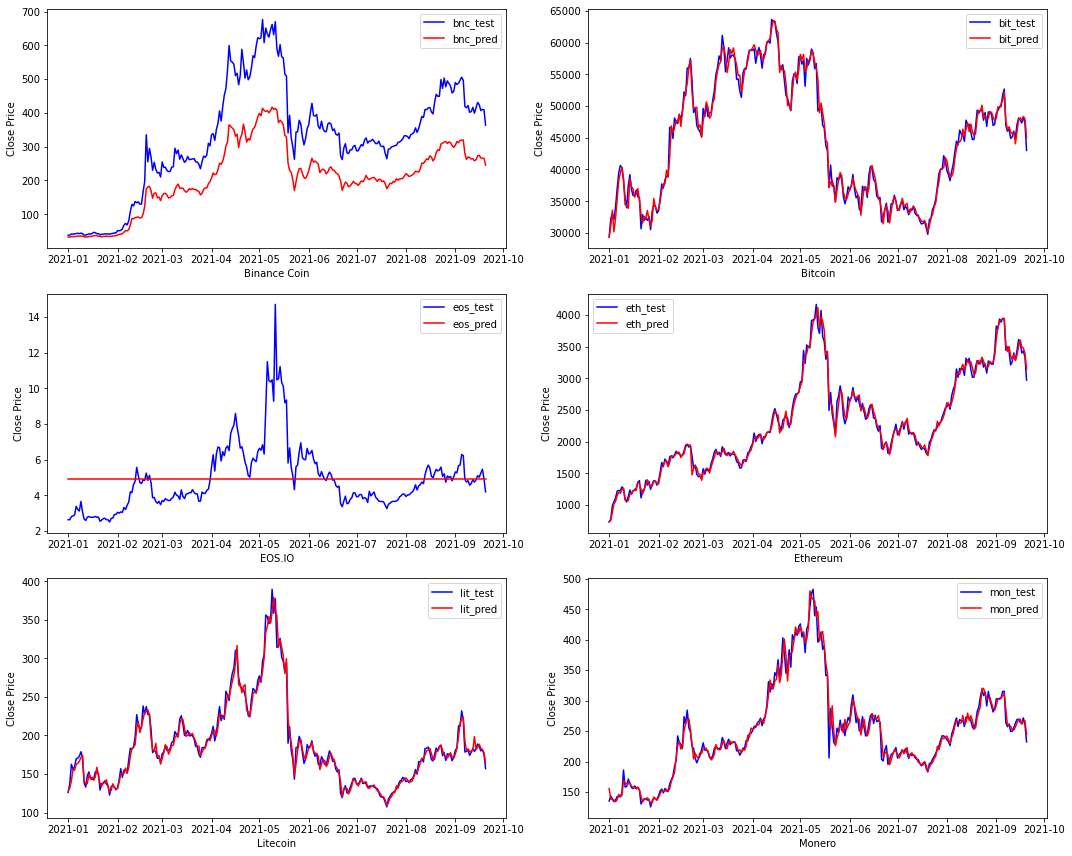

In [44]:
# visualize the prediction of neural network for each cryptocurrency in 2021
times = bnc_test.index
fig = plt.figure(figsize=(15,12))
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test')
plt.plot(times, y_pred_nn_bnc, 'r', label='bnc_pred')
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Close Price')

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test')
plt.plot(times, y_pred_nn_bit, 'r', label='bit_pred')
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Close Price')

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test')
plt.plot(times, y_pred_nn_eos, 'r', label='eos_pred')
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Close Price')

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test')
plt.plot(times, y_pred_nn_eth, 'r', label='eth_pred')
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Close Price')

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test')
plt.plot(times, y_pred_nn_lit, 'r', label='lit_pred')
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Close Price')

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test')
plt.plot(times, y_pred_nn_mon, 'r', label='mon_pred')
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()